In [1]:
%load_ext rpy2.ipython

In [2]:
%%R

#install.packages("tibble")
#install.packages("dplyr")
#install.packages(ggplot2)
#install.packages("caret")
#install.packages("glmnet")

library(tibble)
library(dplyr)
library(ggplot2)
library(caret)
library(pROC)
library(ROSE)
library(glmnet)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: lattice
Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loaded ROSE 0.0-4

Loading required package: Matrix
Loaded glmnet 4.1-8
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


In [3]:
%%R

binary_driving_mode <- function (df_chassis) {
    result <- ifelse(df_chassis$drivingMode == "COMPLETE_AUTO_DRIVE", 1, 0)

    return(result)
}


merge_chassis_pose <- function (df_chassis, df_pose) {
    
    
    df_chassis <- df_chassis[order(df_chassis$time), ]
    df_pose <- df_pose[order(df_pose$time), ]
    
    #make sure data is sorted by time fist

    chassis_time_arr <- df_chassis$time
    pose_time_arr <- df_pose$time

    matched_vector <- c()

    for (chassis_time in chassis_time_arr) {
        abs_time_diff_arr <- abs(pose_time_arr - chassis_time)

        min_index <-  which(abs_time_diff_arr == min(abs_time_diff_arr))
        
        matched_vector <-  c(matched_vector, pose_time_arr[min_index])
    }



    #df_chassis$matched <- df_pose$time[which(abs(pose_time_arr - df_chassis$time) == min(abs(pose_time_arr - df_chassis$time)))]
    df_chassis$matched <-  matched_vector
    df_pose$matched <-  df_pose$time


    return (list(df_chassis = df_chassis, df_pose = df_pose))


}

latlongStdDev <- function(df_pose){
    x <- df_pose["latitudeStdDev"]
    y <- df_pose["longitudeStdDev"]
    r <- sqrt(x^2 + y^2)

    return(r)

}

In [4]:
%%R
# Defining GMIDs for Red Routes
# Am creating a list of GMIDs for processing
red_route_gmIDs  <- c(
     '61b12e7a-f234-11ee-bb33-fb353e7798cd',
'fcc6fcd2-f013-11ee-b966-fb353e7798cd',
'05c7c824-cab8-11ee-aa4d-1d66adf2f0c7',
'211bdb36-f0da-11ee-ba1b-fb353e7798cd',
'868de15e-f3b3-11ee-bb4e-fb353e7798cd',
'72a03d4a-efe9-11ee-b966-fb353e7798cd',
'7fb7b9c0-c881-11ee-a7fc-dd032dba19e8',
'96f7a614-f549-11ee-8afa-cb629b0d53e6',
'1bbbfbae-c839-11ee-a7fc-dd032dba19e8',
'622bd2e8-f0e4-11ee-ba1f-fb353e7798cd',
'9798fe24-f143-11ee-ba78-fb353e7798cd',
'88dd6fbe-f224-11ee-bb21-fb353e7798cd',
'c9c6856c-d33c-11ee-b437-336917683bb8',
'd12cd1c4-caec-11ee-909c-e1dc60cf66f9',
'817d6848-efb6-11ee-b966-fb353e7798cd',
'1b6aca0e-efdf-11ee-b966-fb353e7798cd',
'41b67a28-f52f-11ee-8afa-cb629b0d53e6',
'fc211bb2-efca-11ee-b966-fb353e7798cd',
'84d96f18-f214-11ee-bb13-fb353e7798cd',
'fe973c9c-f53c-11ee-8afa-cb629b0d53e6',
'3151e9e2-eff3-11ee-b966-fb353e7798cd',
'c0555ef0-f50f-11ee-8afa-cb629b0d53e6',
'f711e68e-f0e1-11ee-ba1f-fb353e7798cd',
'c338788a-d324-11ee-b437-336917683bb8',
'd21965e6-f0fa-11ee-ba37-fb353e7798cd',
'88a68dd8-eef9-11ee-9385-ef789ffde1d3',
'f41cbd44-eff8-11ee-b966-fb353e7798cd',
'43a1a35e-f362-11ee-bb4e-fb353e7798cd',
'6d2ea45a-c839-11ee-a7fc-dd032dba19e8',
'01e65360-efd4-11ee-b966-fb353e7798cd',
'7cbd932e-f244-11ee-bb3f-fb353e7798cd',
'65cfbfd6-f396-11ee-bb4e-fb353e7798cd',
'94c53148-eeed-11ee-9385-ef789ffde1d3',
'fd1ab258-efa7-11ee-b966-fb353e7798cd',
'e7b934a8-ef1a-11ee-9385-ef789ffde1d3',
'de933de8-f112-11ee-ba4d-fb353e7798cd',
'd3698592-ef9d-11ee-b966-fb353e7798cd',
'dd72fdec-f0cf-11ee-ba0d-fb353e7798cd',
'b82476fe-f1f3-11ee-baff-fb353e7798cd',
'f755cf60-f132-11ee-ba6d-fb353e7798cd',
'853ef120-cad3-11ee-909c-e1dc60cf66f9',
'f0eebb6a-f0dc-11ee-ba1e-fb353e7798cd',
'cf831f42-f353-11ee-bb4e-fb353e7798cd',
'ecebb942-f162-11ee-ba97-fb353e7798cd',
'219f7eb8-ef87-11ee-b966-fb353e7798cd',
'd24820c8-f197-11ee-babe-fb353e7798cd',
'3d2d29ec-ef95-11ee-b966-fb353e7798cd',
'457dc5ee-f02a-11ee-b966-fb353e7798cd',
'2462c9d0-eecd-11ee-9385-ef789ffde1d3',
'51ef6da6-ca9f-11ee-909c-e1dc60cf66f9',
'c25271be-f3a4-11ee-bb4e-fb353e7798cd',
'8347b862-efad-11ee-b966-fb353e7798cd',
'8dbbbf1c-f0ef-11ee-ba29-fb353e7798cd',
'9189a2a8-f121-11ee-ba5b-fb353e7798cd',
'8fa6fe80-c869-11ee-a7fc-dd032dba19e8',
'35518ec4-f153-11ee-ba88-fb353e7798cd',
'2f95c748-f009-11ee-b966-fb353e7798cd',
'8437f77a-cab7-11ee-909c-e1dc60cf66f9',
'2a61b8a8-f528-11ee-8afa-cb629b0d53e6',
'5a4bccf4-effe-11ee-b966-fb353e7798cd'
)

In [5]:
%%R
# Initialize an empty tibble
df_merged <- tibble()

# Loop through each gmID
for (id in red_route_gmIDs) {
  print(id)
  
  # Update the file paths with the correct full paths
  temp_chassis_path <- sprintf(
    "/home/gampadu_linux/Desktop/TDMprivate/data/%s/_apollo_canbus_chassis/%s_apollo_canbus_chassis.csv",
    id, id
  )
  temp_pose_path <- sprintf(
    "/home/gampadu_linux/Desktop/TDMprivate/data/%s/_apollo_sensor_gnss_best_pose/%s_apollo_sensor_gnss_best_pose.csv",
    id, id
  )

  # Check if the files exist
  if (file.exists(temp_chassis_path) && file.exists(temp_pose_path)) {
    # Read the files
    temp_chassis <- as_tibble(read.csv(temp_chassis_path))
    temp_pose <- as_tibble(read.csv(temp_pose_path))
    
    # Process the data
    r <- latlongStdDev(temp_pose)
    temp_pose["latlongStdDev"] <- r
    
    results <- merge_chassis_pose(temp_chassis, temp_pose)
    result_full <- full_join(results$df_chassis, results$df_pose, by = "matched")
    
    # Add binary driving mode
    result_full$binaryDrivingMode <- binary_driving_mode(result_full)
    
    # Append to df_merged
    df_merged <- bind_rows(df_merged, result_full)
  } else {
    warning(sprintf("Files not found for gmID: %s", id))
  }
}

print("Done loading data")

[1] "61b12e7a-f234-11ee-bb33-fb353e7798cd"
[1] "fcc6fcd2-f013-11ee-b966-fb353e7798cd"
[1] "05c7c824-cab8-11ee-aa4d-1d66adf2f0c7"
[1] "211bdb36-f0da-11ee-ba1b-fb353e7798cd"
[1] "868de15e-f3b3-11ee-bb4e-fb353e7798cd"
[1] "72a03d4a-efe9-11ee-b966-fb353e7798cd"
[1] "7fb7b9c0-c881-11ee-a7fc-dd032dba19e8"
[1] "96f7a614-f549-11ee-8afa-cb629b0d53e6"
[1] "1bbbfbae-c839-11ee-a7fc-dd032dba19e8"
[1] "622bd2e8-f0e4-11ee-ba1f-fb353e7798cd"
[1] "9798fe24-f143-11ee-ba78-fb353e7798cd"
[1] "88dd6fbe-f224-11ee-bb21-fb353e7798cd"
[1] "c9c6856c-d33c-11ee-b437-336917683bb8"
[1] "d12cd1c4-caec-11ee-909c-e1dc60cf66f9"
[1] "817d6848-efb6-11ee-b966-fb353e7798cd"
[1] "1b6aca0e-efdf-11ee-b966-fb353e7798cd"
[1] "41b67a28-f52f-11ee-8afa-cb629b0d53e6"
[1] "fc211bb2-efca-11ee-b966-fb353e7798cd"
[1] "84d96f18-f214-11ee-bb13-fb353e7798cd"
[1] "fe973c9c-f53c-11ee-8afa-cb629b0d53e6"
[1] "3151e9e2-eff3-11ee-b966-fb353e7798cd"
[1] "c0555ef0-f50f-11ee-8afa-cb629b0d53e6"
[1] "f711e68e-f0e1-11ee-ba1f-fb353e7798cd"
[1] "c33878

In [6]:
%%R
# Load required library
library(dplyr)

# Split GMIDs into Training and Testing Sets
training_gmIDs <- red_route_gmIDs[1:55]  # First 55 GMIDs (80%)
testing_gmIDs <- red_route_gmIDs[56:60] # Last 5 GMIDs

# Filter df_merged for training and testing data based on GMIDs
train_data <- df_merged %>% filter(groupMetadataID.x %in% training_gmIDs)
test_data <- df_merged %>% filter(groupMetadataID.x %in% testing_gmIDs)

# Check the number of rows in each dataset
print(paste("Training data rows:", nrow(train_data)))
print(paste("Testing data rows:", nrow(test_data)))

# Verify if test_data is not empty
if (nrow(test_data) == 0) {
  print("Error: test_data is empty. Check GMID filtering.")
}


[1] "Training data rows: 3001134"
[1] "Testing data rows: 293396"


In [7]:
%%R
training_gmIDs

 [1] "61b12e7a-f234-11ee-bb33-fb353e7798cd"
 [2] "fcc6fcd2-f013-11ee-b966-fb353e7798cd"
 [3] "05c7c824-cab8-11ee-aa4d-1d66adf2f0c7"
 [4] "211bdb36-f0da-11ee-ba1b-fb353e7798cd"
 [5] "868de15e-f3b3-11ee-bb4e-fb353e7798cd"
 [6] "72a03d4a-efe9-11ee-b966-fb353e7798cd"
 [7] "7fb7b9c0-c881-11ee-a7fc-dd032dba19e8"
 [8] "96f7a614-f549-11ee-8afa-cb629b0d53e6"
 [9] "1bbbfbae-c839-11ee-a7fc-dd032dba19e8"
[10] "622bd2e8-f0e4-11ee-ba1f-fb353e7798cd"
[11] "9798fe24-f143-11ee-ba78-fb353e7798cd"
[12] "88dd6fbe-f224-11ee-bb21-fb353e7798cd"
[13] "c9c6856c-d33c-11ee-b437-336917683bb8"
[14] "d12cd1c4-caec-11ee-909c-e1dc60cf66f9"
[15] "817d6848-efb6-11ee-b966-fb353e7798cd"
[16] "1b6aca0e-efdf-11ee-b966-fb353e7798cd"
[17] "41b67a28-f52f-11ee-8afa-cb629b0d53e6"
[18] "fc211bb2-efca-11ee-b966-fb353e7798cd"
[19] "84d96f18-f214-11ee-bb13-fb353e7798cd"
[20] "fe973c9c-f53c-11ee-8afa-cb629b0d53e6"
[21] "3151e9e2-eff3-11ee-b966-fb353e7798cd"
[22] "c0555ef0-f50f-11ee-8afa-cb629b0d53e6"
[23] "f711e68e-f0e1-11ee-ba1f-fb

In [8]:
%%R
testing_gmIDs

[1] "35518ec4-f153-11ee-ba88-fb353e7798cd"
[2] "2f95c748-f009-11ee-b966-fb353e7798cd"
[3] "8437f77a-cab7-11ee-909c-e1dc60cf66f9"
[4] "2a61b8a8-f528-11ee-8afa-cb629b0d53e6"
[5] "5a4bccf4-effe-11ee-b966-fb353e7798cd"


In [9]:
%%R
# Train a Logistic Regression Model
model <- glm(
  binaryDrivingMode ~ speedMps + throttlePercentage + brakePercentage + steeringPercentage + latlongStdDev,
  data = train_data,
  family = binomial
)

summary(model)


Call:
glm(formula = binaryDrivingMode ~ speedMps + throttlePercentage + 
    brakePercentage + steeringPercentage + latlongStdDev, family = binomial, 
    data = train_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2500   0.6514   0.6974   0.7304   3.4205  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)         0.8500473  0.0050512  168.28  < 2e-16 ***
speedMps            0.0204820  0.0002559   80.04  < 2e-16 ***
throttlePercentage  0.0020149  0.0001203   16.75  < 2e-16 ***
brakePercentage     0.0009052  0.0001596    5.67 1.42e-08 ***
steeringPercentage  0.0145121  0.0001556   93.26  < 2e-16 ***
latlongStdDev      -0.0564894  0.0007851  -71.95  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3246295  on 3001133  degrees of freedom
Residual deviance: 3212697  on 3001128  degrees of freedom
AIC: 3212709

Numb

In [10]:
%%R
 # Predict on the test set
 predictions <- predict(model, test_data, type = "response")

 #Covert probabilities to binary classes (0 or 1)
 predicted_classes <- ifelse(predictions > 0.5, 1, 0)

 # Calculate accuracy
 accuracy <- mean(predicted_classes == test_data$binaryDrivingMode)

 # Print the accuracy
print(paste("Accuracy:", accuracy))

[1] "Accuracy: 0.813450081119034"


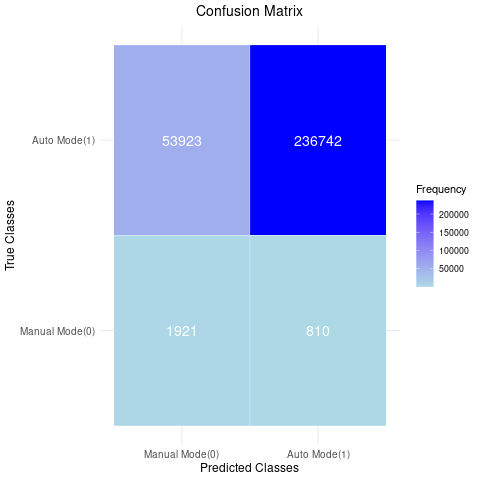

In [11]:
%%R
# Load required libraries
library(ggplot2)
library(caret)

# Map the values to labels (1 -> "Auto_mode", 0 -> "Manual")
predicted_classes_labeled <- factor(predicted_classes, levels = c(0,1), labels = c("Manual Mode(0)", "Auto Mode(1)"))
actual_classes_labeled <- factor (test_data$binaryDrivingMode, levels = c(0,1), labels = c("Manual Mode(0)", "Auto Mode(1)"))

# Generate the confusion matrix
cm <- confusionMatrix(predicted_classes_labeled, actual_classes_labeled)
cm_table <- as.data.frame(cm$table)

# Rename columns for better understanding
colnames(cm_table) <- c("Actual", "Predicted", "Frequency")

# Create the colored confusion matrix plot
ggplot(cm_table, aes(x = Predicted, y = Actual, fill = Frequency)) +
  geom_tile(color = "white") +
  scale_fill_gradient(low = "lightblue", high = "blue", name = "Frequency") +
  geom_text(aes(label = Frequency), color = "white", size = 5) +
  labs(title = "Confusion Matrix", x = "Predicted Classes", y = "True Classes") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, size = 14),
        axis.title = element_text(size = 12),
        axis.text = element_text(size = 10))

Area under the curve: 0.6816


Setting levels: control = 0, case = 1
Setting direction: controls < cases


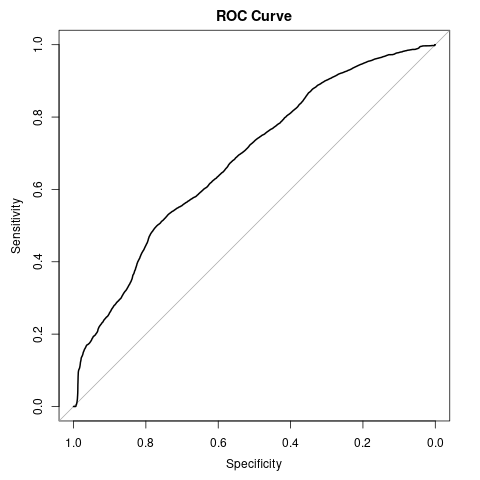

In [12]:
%%R

library(pROC)
roc_obj <- roc(test_data$binaryDrivingMode, predictions)
plot(roc_obj, main = "ROC Curve")
auc(roc_obj)

In [13]:
%%R

#Manually calculating the confusion matrix values
TP <- 58341
FP <- 0
FN <- 9982
TN <- 0

# Calculate Metrics
accuracy <- (TP + TN) / (TP + TN + FP + FN)
precision <- TP / (TP + FP)
recall <- TP / (TP + FN)

#Print Metrics
cat("Accuracy:", accuracy, "\n")
cat("Precision:", precision, "\n")
cat("Recall:", recall, "\n")

Accuracy: 0.8538999 
Precision: 1 
Recall: 0.8538999 


In [15]:
%%R
#Filter the dataset for Complete Auto Drive predictions

#Defining the 10 gmIDs am working with
selected_gmIDs <- c(
    '35518ec4-f153-11ee-ba88-fb353e7798cd','2f95c748-f009-11ee-b966-fb353e7798cd','8437f77a-cab7-11ee-909c-e1dc60cf66f9','2a61b8a8-f528-11ee-8afa-cb629b0d53e6',
                    '5a4bccf4-effe-11ee-b966-fb353e7798cd'
)


complete_auto_drive <- df_merged %>%
                                      
    filter(binaryDrivingMode == 1 & groupMetadataID.x %in% selected_gmIDs)

# Extract latitude and longitude
latitude_list <- complete_auto_drive$latitude
longitude_list <- complete_auto_drive$longitude


#  Save Latitutde and Longitude Lists
write.csv(latitude_list, "latitude_list.csv", row.names = FALSE)
write.csv(longitude_list, "longitude_list.csv", row.names = FALSE)

print("Latitude and Longitude lists saved successfully.")

[1] "Latitude and Longitude lists saved successfully."


In [16]:
%%R
latitude_data <- read.csv("latitude_list.csv")
longitude_data <- read.csv("longitude_list.csv")

head(latitude_data)

         x
1 39.36526
2 39.36526
3 39.36526
4 39.36526
5 39.36535
6 39.36535


In [17]:
%%R
head(longitude_data)

          x
1 -82.10222
2 -82.10222
3 -82.10222
4 -82.10222
5 -82.10209
6 -82.10209
